In [1]:
# Setup

import networkx as nx
import itertools as it
import matplotlib.pyplot as plt
import math
import scipy
import pickle
import os
import logging

plt.rcParams['figure.figsize'] = [1000, 1000]
plt.rcParams['figure.dpi'] = 300

logging.basicConfig(filename=f"Default_Log.txt", level=logging.INFO, format='%(asctime)s %(message)s')
if not os.path.exists("Graphs"):
    os.mkdir("Graphs")
os.chdir("Graphs")
BaseDirectory = os.getcwd()

In [2]:
# Graph Drawing/Exporting

def _draw_graph(Graph):
    Dimension = 1
    fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension)
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='white')
    axes.set_title("Graph 0")
    plt.show()
    plt.close()
    
def _draw_graph_list(GraphList, Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension)
        nx.draw_circular(GraphList[0], ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='silver')
        axes.set_title("Graph 0")
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        fig,axes = plt.subplots(nrows=Dimension,ncols=Dimension)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    axes[x,y].set_title(Names[GraphCounter])
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], with_labels=True, edge_color='black', node_color='black', font_color='silver')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.show()
    plt.close()
    return

def _save_coloring(ColoringList, HostGraph = None, FileName = "Default"):
#     This function saves specifically a red blue coloring
    
    fig,axes = plt.subplots(nrows=1, ncols=3)
    nx.draw_circular(ColoringList[0], ax=axes[0], with_labels=True, edge_color="red", node_color='black', font_color='silver')
    axes[0].set_title("Red Subgraph")
    
    nx.draw_circular(ColoringList[1], ax=axes[1], with_labels=True, edge_color="blue", node_color='black', font_color='silver')
    axes[1].set_title("Blue Subgraph")
    
    if HostGraph == None:
        HostGraph = nx.compose(ColoringList[0], ColoringList[1])
    nx.draw_circular(HostGraph, ax=axes[2], with_labels=True, edge_color="black", node_color='black', font_color='silver')
    axes[2].set_title("Host")
    
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

def _save_graph(Graph, FileName = "Default", Name = None):
    if Name == None:
        Name = "Graph"
    fig,axes = plt.subplots(nrows=1, ncols=1)
    nx.draw_circular(Graph, ax=axes, with_labels=True, edge_color="black", node_color="Black", font_color="silver")
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

def _save_graph_list(GraphList, FileName = "Default", Names = None):
    if Names == None:
        Names = []
        for i in range(len(GraphList)):
            Names.append(f"Graph {i}")
    if len(GraphList) <= 0:
        return
    elif len(GraphList) == 1:
        Dimension = 1
        fig,axes = plt.subplots( nrows=Dimension, ncols=Dimension)
        nx.draw_circular(GraphList[0], ax=axes, with_labels=True, edge_color='black', node_color='black', font_color='silver')
        axes.set_title("Graph 0")
    else:
        Dimension = math.ceil(math.sqrt(len(GraphList)))
        fig,axes = plt.subplots( nrows=Dimension, ncols=Dimension)
        GraphCounter=0
        for x in range(0,Dimension):
            for y in range(0,Dimension):
                if GraphCounter < len(GraphList):
                    axes[x,y].set_title(Names[GraphCounter])
                    nx.draw_circular(GraphList[GraphCounter], ax=axes[x,y], label=f"Graph {GraphCounter}", with_labels=True, edge_color='black', node_color='black', font_color='silver')
                    GraphCounter+=1
                else:
                    nx.draw(nx.null_graph(), ax=axes[x,y])
    plt.tight_layout()
    plt.savefig(f"{FileName}.svg")
    plt.close()
    return

In [3]:
# Graph Manipulations

def _Edge_Subgraph_Generator(Graph):
#     Iterate through selecting 0, 1, 2, ... edges that will be selected from the edge set of the host graph
    for nEdges in range(Graph.size()+1):
        
#         For each given number of edges that will be selected, select each combination of that many edges from the host graph
        for Edges in it.combinations(Graph.edges(),nEdges):
        
#             Add the respective edge-induced subgraph to the list of all subgraphs
            yield nx.edge_subgraph(Graph, Edges).copy()
    
def _Unique_Edge_Subgraph_Generator(Graph):
#     Iterate through each edge-induced subgraph of the input graph
    UniqueSubgraphs = []
    for subgraph in _Edge_Subgraph_Generator(Graph):
        Unique = True
#         Check if the given subgraph is unique. We will assume it is until we find an isomorphic one
        for UniqueSubgraph in UniqueSubgraphs:
            if nx.is_isomorphic(UniqueSubgraph, subgraph):
                Unique = False
                break
#         Now that we've gone through the entire list (or short cirtuited) we can return this subgraph (if it's unique) or conginue to the next subgraph
        if Unique:
            UniqueSubgraphs.append(subgraph)
            yield subgraph
            
def _Return_Unique(Graphs):
    UniqueGraphs = []
#     Iterate through each of the input graphs
    for Graph in Graphs:
        Unique = True
#         Check if the graph is unique. We will assume it is until we find an isomorphic one
        for UniqueGraph in UniqueGraphs:
            if nx.is_isomorphic(UniqueGraph, Graph):
                Unique = False
                break
#         Now that we've gone through the entire list (or short circuited) we can return ass this graph to the list of unique graphs
        if Unique:
            UniqueGraphs.append(Graph)
    return UniqueGraphs
            
def _Union(Graph1, Graph2):
    return _Return_Unique(set(_Unique_Edge_Subgraph_Generator(Graph1)).union(set(_Unique_Edge_Subgraph_Generator(Graph2))))

def _Intersection(GraphList1, GraphList2):
    Intersection = set()
    for Subgraph1 in GraphList1:
        Found = False
        for Subgraph2 in GraphList2:
            if nx.is_isomorphic(Subgraph1, Subgraph2):
                Intersection.add(Subgraph2)
                Found = True
                break
    return list(Intersection)

def _Complement(Graph, Host):
    return Host.edge_subgraph(set(Host.edges())-set(Graph.edges())).copy()

In [4]:
# Miscelaneous Functions

def _get_graph_from_file_name(GraphName):
    if "K_" in GraphName:
        if "," in GraphName:
            n,m=FileName.split(".",1)[0].split("K_",1)[1].split(",")
            n=int(n)
            m=int(m)
            return nx.complete_multipartite_graph(n,m)
        else:
            n=FileName.split(".",1)[0].split("K_",1)[1]
            n=int(n)
            return nx.complete_graph(n)
    elif "C_" in GraphName:
            n=FileName.split(".",1)[0].split("C_",1)[1]
            n=int(n)
            return nx.cycle_graph(n)
    elif "P_" in GraphName:
            n=FileName.split(".",1)[0].split("P_",1)[1]
            n=int(n)
            return nx.path_graph(n)

In [6]:
# Build the unique subgraphs of complete graphs

MaxN = 5
for n in range(1,MaxN+1):
    os.chdir(BaseDirectory)
    
    GraphName = f"K_{n}"

    if not os.path.exists(f"{GraphName}"):
        print(f"Making the folder {GraphName}")
        os.mkdir(f"{GraphName}")
    print(f"Moving into the folder {GraphName}")
    os.chdir(f"{GraphName}")
    print(f"  The folder looks like {os.listdir(os.getcwd())}")
    if os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
        print(f"  {GraphName} has already been investigated, and all edge-induced subgraphs have been generated.")
        continue

    print(f"  Inspecting: {GraphName}")
    Host = nx.complete_graph(n)

    UniqueGraphs = _Return_Unique(set(_Unique_Edge_Subgraph_Generator(Host)))
    print(f"    There are {len(UniqueGraphs)} distinct subgraphs up to isomorphism with at least 1 edge of {GraphName}.")

    with open(f"{GraphName}.UniqueGraphs.pickle", "wb") as OutFile:
        pickle.dump(UniqueGraphs, OutFile)
    os.chdir(BaseDirectory)

Moving into the folder K_1
  The folder looks like ['K_1.UniqueGraphs.pickle', 'K_1.Coloring.0.svg', 'K_1.Down.Arrow.Set.svg']
  K_1 has already been investigated, and all edge-induced subgraphs have been generated.
Moving into the folder K_2
  The folder looks like ['K_2.Coloring.0.svg', 'K_2.Coloring.1.svg', 'K_2.UniqueGraphs.pickle', 'K_2.Down.Arrow.Set.svg']
  K_2 has already been investigated, and all edge-induced subgraphs have been generated.
Moving into the folder K_3
  The folder looks like ['K_3.Coloring.1.svg', 'K_3.Coloring.0.svg', 'K_3.Coloring.2.svg', 'K_3.Coloring.3.svg', 'K_3.Down.Arrow.Set.svg', 'K_3.UniqueGraphs.pickle']
  K_3 has already been investigated, and all edge-induced subgraphs have been generated.
Moving into the folder K_4
  The folder looks like ['K_4.Coloring.2.svg', 'K_4.Coloring.3.svg', 'K_4.Coloring.1.svg', 'K_4.Coloring.0.svg', 'Graphs', 'K_4.Coloring.4.svg', 'K_4.Coloring.5.svg', 'K_4.Coloring.7.svg', 'K_4.Coloring.6.svg', 'K_4.UniqueGraphs.pickle',

Inspecting K_1


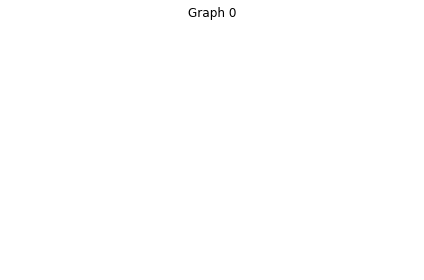

Down arrow set of K_1


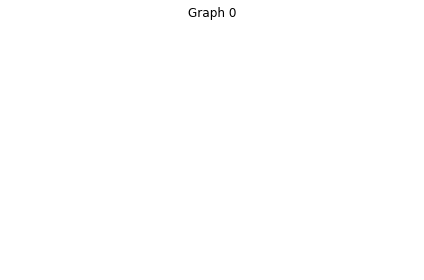

Inspecting K_5


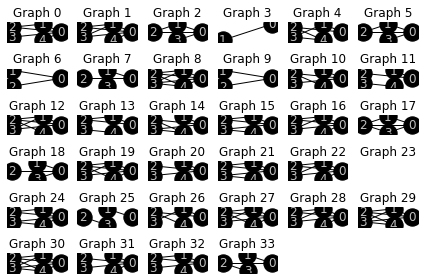

Down arrow set of K_5


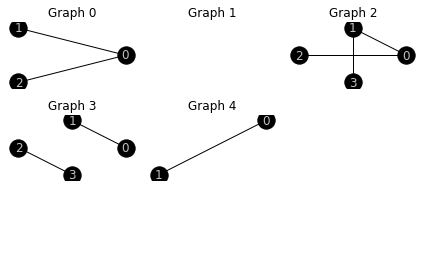

Inspecting K_2


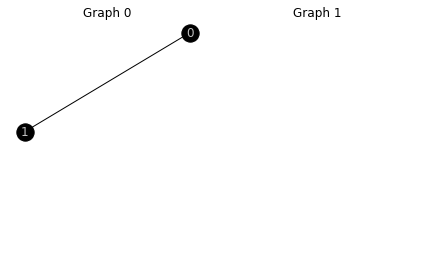

Down arrow set of K_2


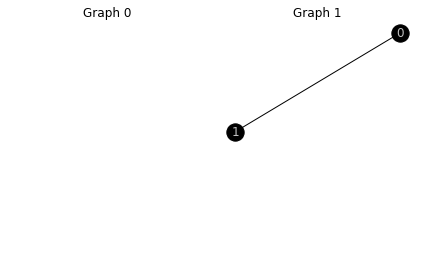

Inspecting K_3


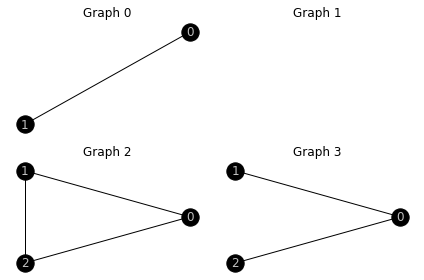

Down arrow set of K_3


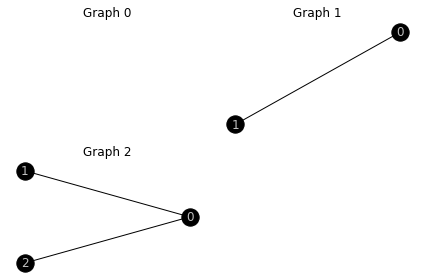

Inspecting K_4


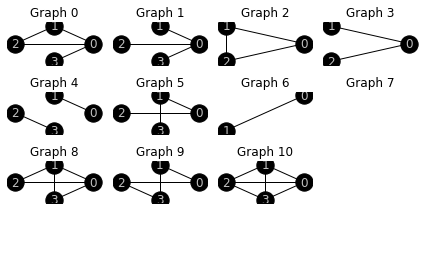

Down arrow set of K_4


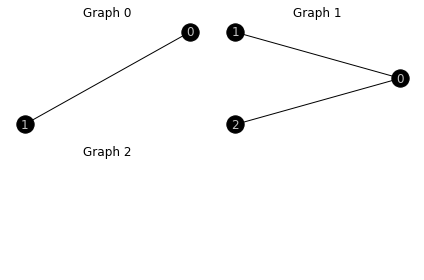

In [7]:
os.chdir(BaseDirectory)
for DirName in os.listdir(BaseDirectory):
    os.chdir(BaseDirectory)
    if os.path.isdir(DirName):
        if "ipynb" not in DirName:
            os.chdir(DirName)
            for FileName in os.listdir(os.getcwd()):
                if ".UniqueGraphs.pickle" in FileName:
                    HostGraph = _get_graph_from_file_name(FileName)
                    GraphName = FileName.split(".",1)[0]
                    print(f"Inspecting {GraphName}")

            #         Pick up the list of unique subgraphs
                    if not os.path.exists(f"{GraphName}.UniqueGraphs.pickle"):
                        continue
                    with open(f"{GraphName}.UniqueGraphs.pickle", "rb") as InputFile:
                        UniqueSubgraphs = pickle.load(InputFile)
                    _draw_graph_list(UniqueSubgraphs)
                    with open(f"{GraphName}.UniqueGraphs.pickle", "rb") as InputFile:
                        Intersections = pickle.load(InputFile)
                        
                    for count,Red in enumerate(UniqueSubgraphs):
                        Blue = _Complement(Red, HostGraph)
                        Unions = _Union(Red, Blue)
                        Intersections = _Intersection(Unions, Intersections)
                        _save_coloring([Red, Blue], HostGraph, f"{GraphName}.Coloring.{count}")
                    print(f"Down arrow set of {GraphName}")
                    _draw_graph_list(Intersections)
                    _save_graph_list(Intersections, f"{GraphName}.Down.Arrow.Set")

In [ ]:
print("Done")